#### This notebook is about using feature selection techniques to obtain best features for binary classificaion (uptrend/downtrend). The target is such that Target(t)=1 if SMA(t+n)>SMA(t), else Target(t)=-1, where n is the number of days to be averaged. The purpose of this is to smooth noise and increase accuracy in the long term forecast.

In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from technical_indicators import *

pd.set_option("display.max_columns", 15)
pd.set_option("display.width", 500)
pd.set_option("display.max_rows", 100)

# warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

### Setting up data 

In [44]:
df = pd.read_csv('Data/GBP_USD_Daily.csv', index_col=0)
df = moving_average(df, 5)
df = moving_average(df, 8)
df = moving_average(df, 10)
df = moving_average(df, 13)
df = moving_average(df, 15)
df = moving_average(df, 20)
df = moving_average(df, 21)
df = EMA(df, 5)
df = EMA(df, 10)
df = EMA(df, 15)
df = EMA(df, 20)
df = MACD(df, 12, 26, 9)
df = MACD(df, 21, 55, 13)
df = stochastic_oscillator(df, 5)
df = stochastic_oscillator(df, 8)
df = stochastic_oscillator(df, 10)
df = stochastic_oscillator(df, 13)
df = stochastic_oscillator(df, 15)
df = stochastic_oscillator(df, 20)
df = stochastic_oscillator(df, 21)
df = williams_R(df, 5)
df = williams_R(df, 7)
df = williams_R(df, 8)
df = williams_R(df, 10)
df = williams_R(df, 13)
df = williams_R(df, 14)
df = williams_R(df, 15)
df = williams_R(df, 20)
df = williams_R(df, 21)
df = relative_strength_index(df, 5)
df = relative_strength_index(df, 7)
df = relative_strength_index(df, 8)
df = relative_strength_index(df, 10)
df = relative_strength_index(df, 13)
df = relative_strength_index(df, 14)
df = relative_strength_index(df, 15)
df = relative_strength_index(df, 20)
df = relative_strength_index(df, 21)
df = momentum(df, 5)
df = momentum(df, 7)
df = momentum(df, 8)
df = momentum(df, 10)
df = momentum(df, 13)
df = momentum(df, 14)
df = momentum(df, 15)
df = momentum(df, 20)
df = momentum(df, 21)
df = change_rate(df, 1)
df = change_rate(df, 2)
df = change_rate(df, 3)
df = change_rate(df, 4)
df = change_rate(df, 5)
df = average_true_range(df, 7)
df = average_true_range(df, 14)
df = average_true_range(df, 21)
df = average_directional_index_and_DI(df, 5)
df = average_directional_index_and_DI(df, 7)
df = average_directional_index_and_DI(df, 8)
df = average_directional_index_and_DI(df, 10)
df = average_directional_index_and_DI(df, 13)
df = average_directional_index_and_DI(df, 14)
df = average_directional_index_and_DI(df, 15)
df = average_directional_index_and_DI(df, 20)
df = average_directional_index_and_DI(df, 21)
df.dropna(inplace=True)

In [45]:
df.describe()

,Price,Open,High,Low,Change,5ma,8ma,...,ADX 15,+DI 20,-DI 20,ADX 20,+DI 21,-DI 21,ADX 21
count,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000,...,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000,4914.000000
mean,1.602178,1.602148,1.608862,1.595076,-0.000031,1.602311,1.602411,...,0.234057,0.198567,0.204613,0.202702,0.198546,0.204671,0.197860
std,0.201222,0.201164,0.201618,0.200771,0.005780,0.200940,0.200745,...,0.096127,0.054014,0.058823,0.084031,0.052717,0.057378,0.082104
min,1.204800,1.204400,1.209000,1.145200,-0.080600,1.215580,1.220113,...,0.078207,0.049413,0.053506,0.069808,0.052473,0.056284,0.067558
25%,1.458900,1.459300,1.466300,1.451600,-0.003200,1.458425,1.458162,...,0.165231,0.162045,0.164889,0.142294,0.163074,0.165874,0.138608
50%,1.578050,1.577800,1.583650,1.570550,0.000100,1.577190,1.577406,...,0.208020,0.195661,0.199450,0.178131,0.195721,0.199701,0.173453
75%,1.738525,1.737475,1.745300,1.731425,0.003200,1.740505,1.740972,...,0.279988,0.232134,0.238190,0.244020,0.231399,0.237017,0.238192
max,2.107800,2.106700,2.116300,2.097200,0.030900,2.093680,2.089913,...,0.576310,0.406126,0.531224,0.479091,0.401098,0.520459,0.473535


In [46]:
def SMA_classification(df, n):
    df['Target ma'] = df['Price'].rolling(window=n, min_periods=n).mean()
    df['Target ma'] = df['Target ma'].round(4)
    df.dropna(inplace=True)
    df['Target'] = np.where(df['Target ma'.format(n)].shift(-n) > df['Target ma'], 1, -1)
    df.drop(columns=['Target ma'], inplace=True)
    df.dropna(inplace=True)

    return df

look_ahead = 5
df = SMA_classification(df, look_ahead)
df.drop(columns=['Change'], inplace=True)
df.dropna(inplace=True)

In [47]:
tmp_df = df.copy()
col_name = list(tmp_df)
x = tmp_df.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
tmp_df = pd.DataFrame(x_scaled, columns=col_name)

# normalized_df = (df-df.min())/(df.max()-df.min())

X = tmp_df.iloc[:,:-1]  #independent columns
y = tmp_df.iloc[:,-1] # target

best_features = SelectKBest(score_func=chi2, k='all')
new_fit = best_features.fit(X.values, y.values)
df_scores = pd.DataFrame(new_fit.scores_)
df_columns = pd.DataFrame(X.columns)

# concatenate two dataframes for visualization 
feature_score = pd.concat([df_columns, df_scores], axis=1)
feature_score.columns = ['Features', 'Score']  #naming the dataframe columns

# print(feature_score.nlargest(df.shape[1]-1, 'Score'))
print(feature_score.nlargest(20, 'Score'))
feature_score.sort_values(ascending=False, by='Score', inplace=True)
print(list(feature_score['Features'].head(20)))

   Features       Score
31    %R W5  200.642545
17    %K_W5  189.626538
32    %R W7  179.837063
33    %R W8  169.484310
19    %K_W8  160.012911
34   %R W10  147.600985
21   %K_W10  139.433653
35   %R W13  120.234216
23   %K_W13  113.754735
36   %R W14  112.871667
37   %R W15  105.873123
25   %K_W15   99.872007
18    %D_W5   97.041591
38   %R W20   81.106868
39   %R W21   77.738753
27   %K_W20   76.414109
20    %D_W8   75.999340
29   %K_W21   73.269212
40    RSI 5   72.436521
22   %D_W10   63.041501
['%R W5', '%K_W5', '%R W7', '%R W8', '%K_W8', '%R W10', '%K_W10', '%R W13', '%K_W13', '%R W14', '%R W15', '%K_W15', '%D_W5', '%R W20', '%R W21', '%K_W20', '%D_W8', '%K_W21', 'RSI 5', '%D_W10']


%K_W5            0.047392
%R W5            0.042158
%D_W5            0.038434
%R W8            0.025438
momentum 5       0.022088
change_rate 3    0.021987
RSI 13           0.016056
%K_W8            0.014606
change_rate 4    0.014094
%R W10           0.013803
%R W14           0.013501
%R W7            0.013448
RSI 5            0.013026
%K_W10           0.012717
MACD_21,55,13    0.012306
%K_W13           0.011085
-DI 5            0.010529
ADX 20           0.010325
%K_W20           0.010306
change_rate 2    0.010137
dtype: float64
['%K_W5', '%R W5', '%D_W5', '%R W8', 'momentum 5', 'change_rate 3', 'RSI 13', '%K_W8', 'change_rate 4', '%R W10', '%R W14', '%R W7', 'RSI 5', '%K_W10', 'MACD_21,55,13', '%K_W13', '-DI 5', 'ADX 20', '%K_W20', 'change_rate 2']


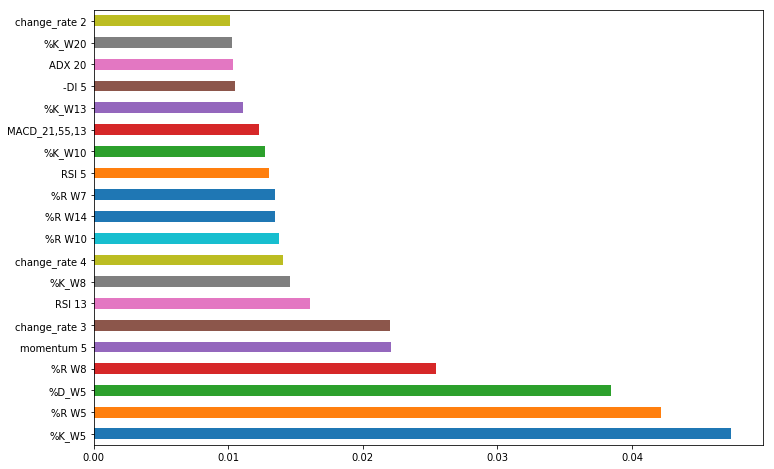

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X, y)

# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12,8))

tmp_df = feat_importances.nlargest(20)
print(tmp_df)
print(tmp_df.index.tolist())

plt.show()

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, y)

features = list(df.columns[:-1])
state = list(fit.support_)
rank = list(fit.ranking_)

data = {'Name': features, 'State': state, 'Rank': rank}
new_df = pd.DataFrame(data)

new_df.drop(new_df[new_df.State == False].index, inplace=True)

print(new_df)
print(list(new_df['Name']))

             Name  State  Rank
16  MACD_21,55,13   True     1
31          %R W5   True     1
42          RSI 8   True     1
50     momentum 7   True     1
52    momentum 10   True     1
57    momentum 21   True     1
58  change_rate 1   True     1
59  change_rate 2   True     1
60  change_rate 3   True     1
61  change_rate 4   True     1
62  change_rate 5   True     1
63          ATR 7   True     1
64   ATR_scaled 7   True     1
68  ATR_scaled 21   True     1
69          +DI 5   True     1
70          -DI 5   True     1
72          +DI 7   True     1
73          -DI 7   True     1
90         +DI 20   True     1
93         +DI 21   True     1
['MACD_21,55,13', '%R W5', 'RSI 8', 'momentum 7', 'momentum 10', 'momentum 21', 'change_rate 1', 'change_rate 2', 'change_rate 3', 'change_rate 4', 'change_rate 5', 'ATR 7', 'ATR_scaled 7', 'ATR_scaled 21', '+DI 5', '-DI 5', '+DI 7', '-DI 7', '+DI 20', '+DI 21']


In [50]:
from sklearn.linear_model import Ridge


def ridge_coef_compute(df, X, y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(X,y)

    col_names = list(df.columns[:-1])
    coefs = ridge.coef_
    
    lst = zip(coefs, col_names)
    
    coefs = list(coefs)
        
    data = {'Feature': col_names, 'coef': coefs}
    ridge_df = pd.DataFrame(data)
    
    return ridge_df

ridge_df = ridge_coef_compute(df, X, y)
ridge_df.sort_values(by=['coef'], ascending=False, inplace=True)
print("Ridge model:\n", ridge_df.head(10))
print(ridge_df.tail(10))

print(list(ridge_df['Feature'].head(5)))
print(list(ridge_df['Feature'].tail(5)))

Ridge model:
           Feature      coef
60  change_rate 3  0.572687
61  change_rate 4  0.461969
68  ATR_scaled 21  0.322411
67         ATR 21  0.322411
58  change_rate 1  0.318822
20          %D_W8  0.280281
57    momentum 21  0.275205
75          +DI 8  0.266019
48         RSI 21  0.259798
17          %K_W5  0.252640
          Feature      coef
52    momentum 10 -0.254802
76          -DI 8 -0.273966
73          -DI 7 -0.290066
90         +DI 20 -0.351870
50     momentum 7 -0.360502
3             Low -0.361014
93         +DI 21 -0.399917
16  MACD_21,55,13 -0.400578
28         %D_W20 -0.410435
62  change_rate 5 -0.493128
['change_rate 3', 'change_rate 4', 'ATR_scaled 21', 'ATR 21', 'change_rate 1']
['Low', '+DI 21', 'MACD_21,55,13', '%D_W20', 'change_rate 5']


change_rate 3    0.07
ATR 21           0.06
ADX 10           0.05
MACD_21,55,13    0.04
change_rate 4    0.04
5ma              0.03
change_rate 1    0.03
ATR 7            0.03
ATR_scaled 21    0.03
ADX 5            0.03
ADX 15           0.03
+DI 21           0.03
Open             0.02
High             0.02
ema5             0.02
ema20            0.02
MACD_12,26,9     0.02
%K_W5            0.02
%R W5            0.02
momentum 7       0.02
dtype: float64
['change_rate 3', 'ATR 21', 'ADX 10', 'MACD_21,55,13', 'change_rate 4', '5ma', 'change_rate 1', 'ATR 7', 'ATR_scaled 21', 'ADX 5', 'ADX 15', '+DI 21', 'Open', 'High', 'ema5', 'ema20', 'MACD_12,26,9', '%K_W5', '%R W5', 'momentum 7']


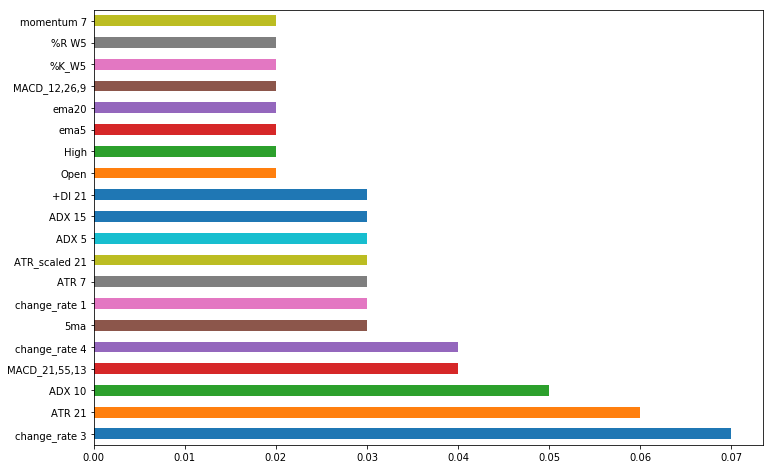

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y)

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12,8))

tmp_df = feat_importances.nlargest(20)
print(tmp_df)
print(tmp_df.index.tolist())

plt.show()